In [188]:
import numpy as np
import matplotlib.pylab as plot
import math as m

In [189]:
class Constants:
    """
    Contains parameters for the simulation
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
class System:
    """
    Contains the system parameters
    """
    def __init__(self, envk, shtk, projk, simk): 
        
        #derived shot params 
        theta_rad = m.radians(theta)

        #derived environmental params 
        waterVaporSaturationPressure = 6.1078 * 10 ** ((7.5 * envk.temperature) / (237.3 + envk.temperature)) # saturation pressure of water vapor in hPa
        vaporPartialPressure = envk.relativeHumidity * waterVaporSaturationPressure*100 # partial pressure of water vapor in Pa
        dryAirPartialPressure = (envk.airPressure*1000) - vaporPartialPressure # partial pressure of dry air in Pa
        airDensity = (dryAirPartialPressure / (envk.RDryAir * (envk.temperature + 273.15))) + vaporPartialPressure / (envk.RWaterVapor * (envk.temperature + 273.15)) # air density in kg/m^3

        #derived projectile params
        crossSectionalArea = m.pi * projk.radius ** 2 # surface area of the projectile in m^2
        dragConstant = 0.5 * projk.cd * airDensity * crossSectionalArea # drag constant in kg/m
        characteristicLength = 2 * projk.radius # characteristic length in meters

        #derived simulation params
        t = np.linspace(simk.startTime, simk.endTime, num=simk.simulations) # Set time as 'continous' parameter.
        timestep = (endTime - startTime) /simk.simulations

        self.environmentalConstants = Constants(
            g = envk.g,
            temperature = envk.temperature,
            relativeHumidity = envk.relativeHumidity,
            airPressure = envk.airPressure,
            RDryAir = envk.RDryAir,
            RWaterVapor = envk.RWaterVapor,
            airDensity = airDensity,
        )
        self.simulationConstants = Constants(
            t = t,
            timestep = timestep,
        )
        self.shotConstants = Constants(
            theta = shtk.theta,
            theta_rad = theta_rad,
            v0 = shtk.v0,
            h0 = shtk.h0,
        )
        self.projectileConstants = Constants(
            mass = projk.mass,
            radius = projk.radius,
            cd = projk.cd,
            dragConstant = dragConstant,
            characteristicLength = characteristicLength,
            crossSectionalArea = crossSectionalArea,
        )
        

class projectile:
    """
    Contains the projectile parameters
    """
    def __init__(self, system):
        self.position = np.array([0, system.shotConstants.h0]) # initial position of the projectile
        self.velocity = np.array([v0 * m.cos(system.shotConstants.theta_rad), v0 * m.sin(system.shotConstants.theta_rad)])
        self.acceleration = np.array([0, -system.environmentalConstants.g])
        self.projectileConstants = system.projectileConstants
        self.out = np.array([np.array([]),np.array([])])
    def calculateDrag(self):
        dragx = -self.projectileConstants.dragConstant * np.linalg.norm(self.velocity) * self.velocity[0] / self.projectileConstants.mass
        dragy = -self.projectileConstants.dragConstant * np.linalg.norm(self.velocity) * self.velocity[1] / self.projectileConstants.mass
        return np.array([dragx, dragy])
    def update(self,isDrag):
        if (isDrag): 
            drag = self.calculateDrag()
            self.acceleration = np.array([drag[0], -system.environmentalConstants.g + drag[1]])
        else :
            self.acceleration = np.array([0, -system.environmentalConstants.g])
        self.velocity = np.add(self.velocity,self.acceleration * system.simulationConstants.timestep)
        self.position = np.add(self.position,self.velocity * system.simulationConstants.timestep)
        
        self.out = np.append(self.out,[[self.position[0]],[self.position[1]]],axis=1)
    
    

In [190]:
#initialize variables
environmentalConstants = Constants(
    g = 9.81, # gravitational acceleration
    temperature = 25, # temperature in celsius
    relativeHumidity = 0.5, # relative humidity
    airPressure = 101.325, # partial pressure of dry air in kPa
    RDryAir = 287.058, # specific gas constant for dry air
    RWaterVapor = 461.495 # specific gas constant for water vapor
) 
shotConstants = Constants(
    v0 = 30, # initial velocity
    theta = 30, # initial angle
    h0 = 0 # initial height
)
projectileConstants = Constants(
    cd = 0.47, # drag coefficient
    mass = 0.270, # mass of the projectile in Kg
    radius = 0.12 # radius of the projectile in meters; note that the projectile is assumed to be spherical
)
simulationConstants = Constants(
    simulations = 1000,
    startTime = 0,
    endTime = 10
)

#initialize system
system = System(environmentalConstants, shotConstants, projectileConstants, simulationConstants)

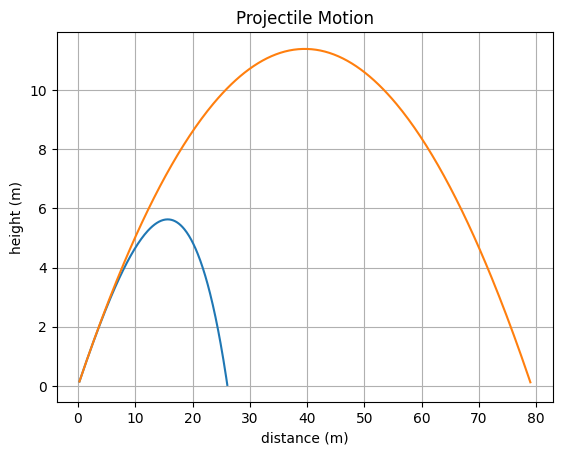

In [191]:
def simulation(system, isDrag):
    proj = projectile(system)
    for t in system.simulationConstants.t:
        proj.update(isDrag)
        if proj.position[1] <= 0:
            break
    
    p = [i for i, j in enumerate(proj.out[1]) if j < 0] # Don't fall through the floor                          
    for i in sorted(p, reverse = True):
        proj.out = np.delete(proj.out, i, axis=1)
    return proj.out

def drawSimulations(system, simulations):
    for sim in simulations:
        plot.plot(sim[0], sim[1])
    plot.xlabel('distance (m)')
    plot.ylabel('height (m)')
    plot.title('Projectile Motion')
    plot.grid(True)
    plot.show()

simulations = [simulation(system, True), simulation(system, False)]
drawSimulations(system, simulations)